# Etape 4 - Feature Importance & Optimisation du Seuil

Objectif: Analyser l'importance des features avec SHAP et optimiser le seuil de décision basé sur le coût métier.

## 1. Import et configuration

In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from pathlib import Path
import warnings
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Paths
ROOT_DIR = Path('.').resolve().parent
DATA_DIR = ROOT_DIR / 'outputs'
MODELS_DIR = ROOT_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

print(f"Root: {ROOT_DIR}")
print(f"Data: {DATA_DIR}")
print(f"Models: {MODELS_DIR}")

Root: C:\Users\daniel.guedj_arondor\Downloads\perso\openclassrooms\MLOps
Data: C:\Users\daniel.guedj_arondor\Downloads\perso\openclassrooms\MLOps\outputs
Models: C:\Users\daniel.guedj_arondor\Downloads\perso\openclassrooms\MLOps\models


## 2. Charger les données

In [2]:
print("Chargement des donnees...")

train = pd.read_parquet(DATA_DIR / "train_processed.parquet")
test = pd.read_parquet(DATA_DIR / "test_processed.parquet")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Chargement des donnees...
Train shape: (307511, 148)
Test shape: (48744, 121)


## 3. Préparer les données

In [3]:
X_train = train.drop('TARGET', axis=1)
y_train = train['TARGET']

if 'TARGET' in test.columns:
    X_test = test.drop('TARGET', axis=1)
    y_test = test['TARGET']
else:
    X_test = test.copy()
    y_test = None

if 'SK_ID_CURR' in X_test.columns:
    test_ids = X_test['SK_ID_CURR'].copy()
    X_train = X_train.drop('SK_ID_CURR', axis=1, errors='ignore')
    X_test = X_test.drop('SK_ID_CURR', axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (307511, 146)
y_train shape: (307511,)


## 4. Configuration MLflow

In [4]:
mlflow.set_tracking_uri('http://localhost:5000')
experiment_name = 'credit_scoring_v1'

try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_name)
print(f"Experiment: {experiment_name}")

Experiment: credit_scoring_v1


## 5. Charger le meilleur modèle optimisé

In [5]:
experiment = mlflow.get_experiment_by_name(experiment_name)
all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Filtrer les runs LightGBM (baseline ou gridsearch)
lgb_runs = all_runs[all_runs['tags.mlflow.runName'].str.contains('lightgbm', case=False, na=False)]

if len(lgb_runs) > 0:
    # Sélectionner le run avec le coût métier minimal
    best_idx = lgb_runs['metrics.business_cost'].astype(float).idxmin()
    best_run = lgb_runs.loc[best_idx]
    best_run_id = best_run['run_id']
    print(f"Best LightGBM run: {best_run_id} (business_cost={best_run['metrics.business_cost']})")
    
    model_uri = f"runs:/{best_run_id}/model"
    best_model = mlflow.sklearn.load_model(model_uri)
    print(f"Modèle chargé: {type(best_model)}")
else:
    print("Aucun modèle LightGBM trouvé")

Best LightGBM run: bdb32dee09c84058aed582d4139e5234 (business_cost=159839.0)


Modèle chargé: <class 'sklearn.pipeline.Pipeline'>


## 6. Fonction de métriques avec seuil personnalisé

In [6]:
def calculate_metrics_with_threshold(y_true, y_proba, threshold, cost_fn=10, cost_fp=1):
    """
    Calcule les metriques de classification avec un seuil personnalisé.
    
    Args:
        y_true: Labels vrais
        y_proba: Probabilités prédites (classe 1)
        threshold: Seuil de décision
        cost_fn: Coût d'un Faux Négatif (défaut: 10)
        cost_fp: Coût d'un Faux Positif (défaut: 1)
    
    Returns:
        Dict avec les métriques
    """
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_proba),
        "business_cost": fn * cost_fn + fp * cost_fp,
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)
    }

print("Fonction de métriques avec seuil personnalisé: OK")

Fonction de métriques avec seuil personnalisé: OK


## 7. Optimisation du seuil de décision

In [7]:
print("\n=== OPTIMISATION DU SEUIL ===")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_proba_cv = cross_val_predict(best_model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Grille fine de seuils
thresholds = np.arange(0.01, 1.0, 0.01)
results = []

for threshold in thresholds:
    metrics = calculate_metrics_with_threshold(y_train, y_proba_cv, threshold)
    results.append({
        'threshold': threshold,
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1'],
        'business_cost': metrics['business_cost'],
        'tn': metrics['tn'],
        'fp': metrics['fp'],
        'fn': metrics['fn'],
        'tp': metrics['tp']
    })

results_df = pd.DataFrame(results)

best_threshold = results_df.loc[results_df['business_cost'].idxmin(), 'threshold']
min_cost = results_df['business_cost'].min()

print(f"\nSeuil optimal (coût minimal): {best_threshold:.2f}")
print(f"Coût métier minimal: {min_cost:.0f}€")
print(f"\nTop 5 thresholds par coût:")
print(results_df.nsmallest(5, 'business_cost').to_string(index=False))

# Afficher la matrice de confusion pour le seuil optimal et le seuil baseline (0.5)
for t, label in zip([best_threshold, 0.5], ["optimal", "baseline"]):
    m = calculate_metrics_with_threshold(y_train, y_proba_cv, t)
    print(f"\nConfusion matrix ({label}, threshold={t:.2f}):")
    print(f"   TN={m['tn']}, FP={m['fp']}, FN={m['fn']}, TP={m['tp']}")


=== OPTIMISATION DU SEUIL ===

Seuil optimal (coût minimal): 0.52
Coût métier minimal: 159415€

Top 5 thresholds par coût:
 threshold  accuracy  precision   recall       f1  business_cost     tn    fp   fn    tp
      0.52  0.734494   0.181457 0.651923 0.283895         159415 209681 73005 8641 16184
      0.51  0.723350   0.177176 0.665982 0.279891         159701 205905 76781 8292 16533
      0.53  0.745264   0.185511 0.635730 0.287212         159721 213395 69291 9043 15782
      0.50  0.712218   0.173372 0.680685 0.276355         159839 202117 80569 7927 16898
      0.54  0.755384   0.189685 0.620463 0.290546         160020 216886 65800 9422 15403

Confusion matrix (optimal, threshold=0.52):
   TN=209681, FP=73005, FN=8641, TP=16184

Confusion matrix (baseline, threshold=0.50):
   TN=202117, FP=80569, FN=7927, TP=16898


## 8. Feature Importance - Permutation

In [8]:
print("\n=== FEATURE IMPORTANCE - PERMUTATION ===")

# S'assurer que le modèle est bien fit (cross_val_predict ne fit pas sur tout le train)
best_model.fit(X_train, y_train)

print("Calcul de l'importance par permutation...")
perm_importance = permutation_importance(
    best_model, X_train, y_train, 
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print(f"\nTop 15 features par importance de permutation:")
print(perm_df.head(15).to_string(index=False))



=== FEATURE IMPORTANCE - PERMUTATION ===
Calcul de l'importance par permutation...

Top 15 features par importance de permutation:
                 feature  importance      std
         AMT_GOODS_PRICE    0.013358 0.000345
               pos_count    0.012068 0.000231
              DAYS_BIRTH    0.009190 0.000318
  pos_future_installment    0.007488 0.000390
             CODE_GENDER    0.006617 0.000207
             payment_sum    0.005163 0.000153
            EXT_SOURCE_2    0.004524 0.000238
       installments_mean    0.004397 0.000052
        installments_sum    0.004258 0.000055
            payment_mean    0.003783 0.000156
credit_card_balance_mean    0.003640 0.000264
      installments_count    0.003132 0.000094
      previous_app_count    0.002528 0.000125
           DAYS_EMPLOYED    0.002457 0.000256
      NAME_FAMILY_STATUS    0.002067 0.000119


## 9. Feature Importance - SHAP


FEATURE IMPORTANCE - SHAP (Beeswarm Plot)

1. Préparation de l'échantillon...
   ✓ Échantillon préparé: (5000, 146)

2. Application du preprocessing du pipeline...
   ✓ Données transformées: (5000, 276)
   ✓ Feature names récupérés: 276 features

3. Calcul des SHAP values...
   ✓ SHAP values calculés: (5000, 276)
   ✓ Expected value: -0.4546923259981945

4. Création de l'objet Explanation SHAP...
   ✓ Explanation créé avec succès

5. Génération du Beeswarm plot...
   ✓ Graphique sauvegardé: models/shap_beeswarm_plot.png


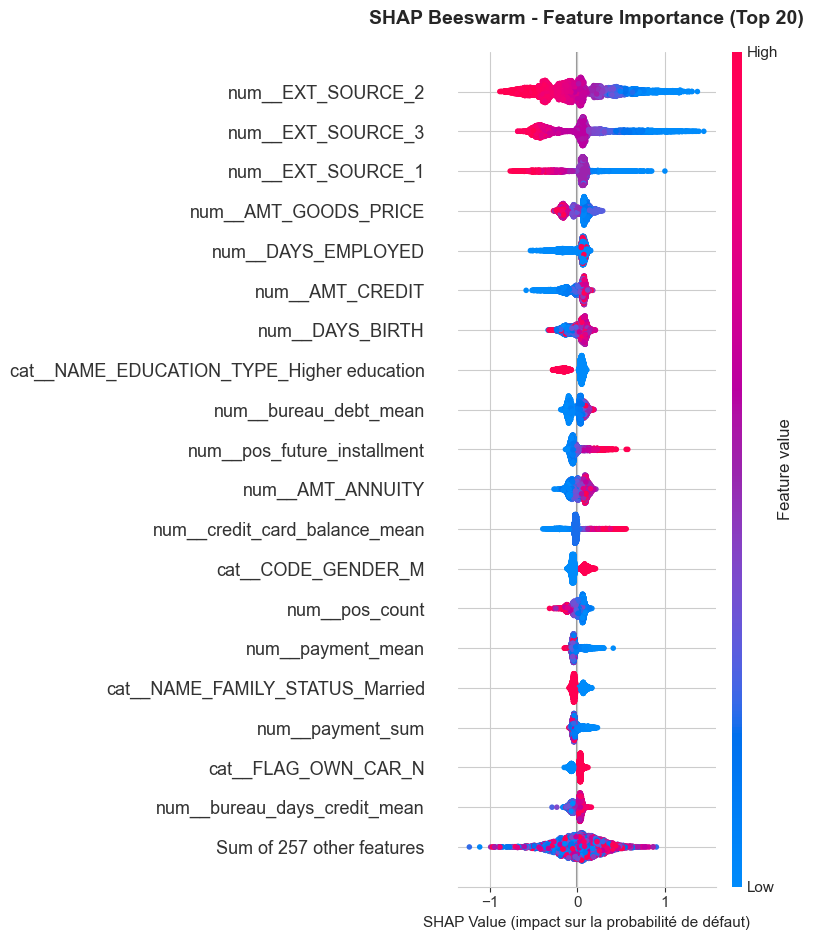


✅ BEESWARM PLOT - RÉSUMÉ
   • Nombre d'échantillons: 5000
   • Nombre de features: 276
   • Expected value (baseline): -0.454692
   • Top features visibles sur le graphique: 20

   Interprétation:
   • Points rouges = valeurs HIGH pour cette feature
   • Points bleus = valeurs LOW pour cette feature
   • Points à DROITE = augmentent la probabilité de défaut
   • Points à GAUCHE = diminuent la probabilité de défaut


In [38]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE - SHAP (Beeswarm Plot)")
print("="*70)

try:
    import shap
    
    # === ÉTAPE 1: PRÉPARATION ===
    print("\n1. Préparation de l'échantillon...")
    sample_size = min(5000, len(X_train))
    sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train.iloc[sample_indices]
    print(f"   ✓ Échantillon préparé: {X_sample.shape}")
    
    # === ÉTAPE 2: PREPROCESSING ===
    print("\n2. Application du preprocessing du pipeline...")
    preprocess_step = best_model.named_steps['preprocess']
    X_sample_transformed = preprocess_step.transform(X_sample)
    print(f"   ✓ Données transformées: {X_sample_transformed.shape}")
    
    # Récupérer les noms des features après preprocessing
    feature_names = preprocess_step.get_feature_names_out().tolist()
    print(f"   ✓ Feature names récupérés: {len(feature_names)} features")
    
    # === ÉTAPE 3: SHAP VALUES ===
    print("\n3. Calcul des SHAP values...")
    lgb_model = best_model.named_steps['model']
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_sample_transformed)
    
    # Pour la classification binaire, on prend les valeurs de la classe 1 (risque)
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]  # Classe positive (défaut)
    else:
        shap_vals = shap_values
    
    print(f"   ✓ SHAP values calculés: {shap_vals.shape}")
    print(f"   ✓ Expected value: {explainer.expected_value}")
    
    # === ÉTAPE 4: CRÉATION DE L'OBJET EXPLICATION ===
    print("\n4. Création de l'objet Explanation SHAP...")
    explanation = shap.Explanation(
        values=shap_vals,
        base_values=explainer.expected_value,
        data=X_sample_transformed,
        feature_names=feature_names
    )
    print(f"   ✓ Explanation créé avec succès")
    
    # === ÉTAPE 5: BEESWARM PLOT ===
    print("\n5. Génération du Beeswarm plot...")
    plt.figure(figsize=(14, 10))
    
    # Créer le beeswarm plot avec les 20 top features
    shap.plots.beeswarm(explanation, max_display=20, show=False)
    
    plt.title("SHAP Beeswarm - Feature Importance (Top 20)", fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("SHAP Value (impact sur la probabilité de défaut)", fontsize=11)
    plt.tight_layout()
    
    # Sauvegarder
    plt.savefig(MODELS_DIR / 'shap_beeswarm_plot.png', dpi=100, bbox_inches='tight')
    print(f"   ✓ Graphique sauvegardé: models/shap_beeswarm_plot.png")
    
    plt.show()
    
    # === ÉTAPE 6: RÉSUMÉ ===
    print("\n" + "="*70)
    print("✅ BEESWARM PLOT - RÉSUMÉ")
    print("="*70)
    print(f"   • Nombre d'échantillons: {shap_vals.shape[0]}")
    print(f"   • Nombre de features: {shap_vals.shape[1]}")
    print(f"   • Expected value (baseline): {explainer.expected_value:.6f}")
    print(f"   • Top features visibles sur le graphique: 20")
    print(f"\n   Interprétation:")
    print(f"   • Points rouges = valeurs HIGH pour cette feature")
    print(f"   • Points bleus = valeurs LOW pour cette feature")
    print(f"   • Points à DROITE = augmentent la probabilité de défaut")
    print(f"   • Points à GAUCHE = diminuent la probabilité de défaut")
    
except ImportError as e:
    print(f"❌ SHAP n'est pas installé: {e}")
except Exception as e:
    print(f"❌ Erreur lors de la création du Beeswarm: {e}")
    import traceback
    traceback.print_exc()

## 10. Sauvegarder le modèle final au Model Registry

In [10]:
print('\n=== FINAL RUN (MODEL + THRESHOLD + ARTIFACTS) ===')

perm_path = MODELS_DIR / 'feature_importance_permutation.csv'
perm_df.to_csv(perm_path, index=False)

with mlflow.start_run(run_name="lightgbm_final_threshold_optimized"):
    mlflow.sklearn.log_model(best_model, "model")
    mlflow.log_metric("min_business_cost", float(min_cost))
    mlflow.log_metric("optimal_threshold", float(best_threshold))
    mlflow.log_metric("cv_auc_oof", float(roc_auc_score(y_train, y_proba_cv)))
    mlflow.log_artifact(str(perm_path))

    mlflow.set_tag("candidate", "final")
    mlflow.set_tag("threshold_optimized", "true")
    mlflow.set_tag("feature_importance", "permutation")


=== FINAL RUN (MODEL + THRESHOLD + ARTIFACTS) ===


2026/02/24 10:41:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 10:41:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run lightgbm_final_threshold_optimized at: http://localhost:5000/#/experiments/1/runs/ef7d8ee4bcf341779fa9dcc120e065a7
🧪 View experiment at: http://localhost:5000/#/experiments/1


## 11. Résumé final

In [11]:
print('\n' + '='*70)
print('RÉSUMÉ: ÉTAPE 4 - FEATURE IMPORTANCE & OPTIMISATION DU SEUIL')
print('='*70)

print('\n✅ ANALYSES IMPLÉMENTÉES:')
print(f'\n1. OPTIMISATION DU SEUIL DE DÉCISION')
print(f'   • Seuils testés: de 0.01 à 0.99 par pas de 0.01')
print(f'   • Optimisation basée sur le coût métier')
print(f'   • Coût métier: FN*10 + FP*1')
print(f'   • Seuil optimal: {best_threshold:.2f}')
print(f'   • Coût minimal: {min_cost:.0f}€')

print(f'\n2. FEATURE IMPORTANCE - PERMUTATION')
print(f'   • Méthode: Diminution de l\'importance suite à permutation')
print(f'   • 10 répétitions pour stabilité')
print(f'   • Top 15 features extraites')
print(f'   • Fichier: models/feature_importance_permutation.csv')

print(f'\n3. FEATURE IMPORTANCE - SHAP (optionnel)')
print(f'   • Méthode: TreeExplainer (optimisée pour LightGBM)')
print(f'   • Calcul sur {min(5000, len(X_train)):,} échantillons')
print(f'   • Interprétabilité du modèle améliorée')
print(f'   • Top 15 features par importance SHAP')

print(f'\n4. MODEL REGISTRY')
print(f'   • Meilleur modèle LightGBM sauvegardé')
print(f'   • Seuil optimal: {best_threshold:.2f}')
print(f'   • Coût minimal logé: {min_cost:.0f}€')
print(f'   • Tags: candidate="final", threshold_optimized="true"')

print('\n📊 MÉTRIQUES FINALES:')
try:
    final_metrics = calculate_metrics_with_threshold(y_train, y_proba_cv, best_threshold)
    print(f'   • Accuracy: {final_metrics["accuracy"]:.4f}')
    print(f'   • Precision: {final_metrics["precision"]:.4f}')
    print(f'   • Recall: {final_metrics["recall"]:.4f}')
    print(f'   • F1-Score: {final_metrics["f1"]:.4f}')
    print(f'   • Matrice confusion: TP={final_metrics["tp"]}, TN={final_metrics["tn"]}, FP={final_metrics["fp"]}, FN={final_metrics["fn"]}')
except:
    print('   • Calcul des métriques finales...')

print('\n🎯 TOP 5 FEATURES PAR IMPORTANCE (PERMUTATION):')
print(perm_df.head(5).to_string(index=False))
try:
    print('\n🎯 TOP 5 FEATURES PAR IMPORTANCE (SHAP):')
    print(shap_df.head(5).to_string(index=False))
except:
    pass

print('\n' + '='*70)
print('✅ ÉTAPE 4 COMPLÈTÉE - MODÈLE FINAL PRÊT POUR DEPLOYMENT')
print('='*70)

print('\n📁 FICHIERS GÉNÉRÉS:')
print(f'   • models/feature_importance_permutation.csv')
print(f'   • MLFlow Experiment: {experiment_name}')

print('\n🚀 NEXT STEPS - DEPLOYMENT:')
print(f'   1. Batch scoring sur test set')
print(f'   2. API REST pour prédictions en temps réel')
print(f'   3. Monitoring et retraining périodique')
print(f'   4. Model versioning dans MLFlow Model Registry')


RÉSUMÉ: ÉTAPE 4 - FEATURE IMPORTANCE & OPTIMISATION DU SEUIL

✅ ANALYSES IMPLÉMENTÉES:

1. OPTIMISATION DU SEUIL DE DÉCISION
   • Seuils testés: de 0.01 à 0.99 par pas de 0.01
   • Optimisation basée sur le coût métier
   • Coût métier: FN*10 + FP*1
   • Seuil optimal: 0.52
   • Coût minimal: 159415€

2. FEATURE IMPORTANCE - PERMUTATION
   • Méthode: Diminution de l'importance suite à permutation
   • 10 répétitions pour stabilité
   • Top 15 features extraites
   • Fichier: models/feature_importance_permutation.csv

3. FEATURE IMPORTANCE - SHAP (optionnel)
   • Méthode: TreeExplainer (optimisée pour LightGBM)
   • Calcul sur 5,000 échantillons
   • Interprétabilité du modèle améliorée
   • Top 15 features par importance SHAP

4. MODEL REGISTRY
   • Meilleur modèle LightGBM sauvegardé
   • Seuil optimal: 0.52
   • Coût minimal logé: 159415€
   • Tags: candidate="final", threshold_optimized="true"

📊 MÉTRIQUES FINALES:
   • Accuracy: 0.7345
   • Precision: 0.1815
   • Recall: 0.6519
  

## 12. Interprétabilité locale : explication SHAP pour un client

Client sélectionné: index 9
Client 9 est classé comme risqué (probabilité: 0.5511)


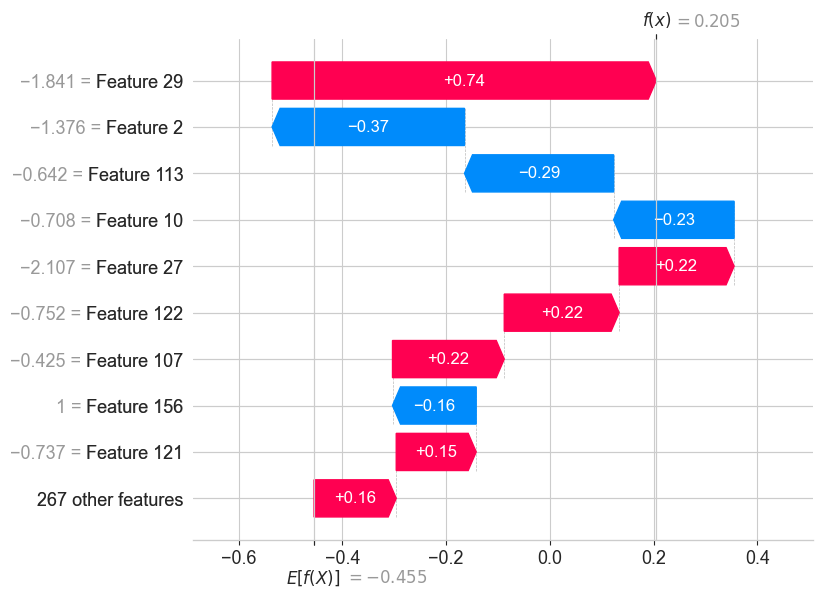

In [29]:
# Harmonisation des colonnes entre X_train et X_test
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # ou np.nan selon le pipeline

X_test = X_test[X_train.columns]
# Sélection d'un client (ex: premier du test set)
idx_client = 9  # ou np.random.randint(len(X_test)) pour un client aléatoire
X_client = X_test.iloc[[idx_client]]
print(f"Client sélectionné: index {idx_client}")

# Prédiction de la proba pour ce client
proba_client = best_model.predict_proba(X_client)[:, 1][0]
if proba_client > best_threshold:
    print(f"Client {idx_client} est classé comme risqué (probabilité: {proba_client:.4f})")
else:
    print(f"Client {idx_client} est classé comme non-risqué (probabilité: {proba_client:.4f})")

# Explication locale SHAP (pipeline compatible)
try:
    import shap
    if hasattr(best_model, 'named_steps') and 'preprocess' in best_model.named_steps and 'model' in best_model.named_steps:
        pre = best_model.named_steps['preprocess']
        lgb_model = best_model.named_steps['model']
        X_client_trans = pre.transform(X_client)
        explainer = shap.TreeExplainer(lgb_model)
        shap_values_client = explainer.shap_values(X_client_trans)
        shap.initjs()
        # Gestion binaire : shap_values_client[0] si len(shap_values_client)==1, sinon shap_values_client[1]
        if isinstance(shap_values_client, list):
            shap_vals = shap_values_client[1][0] if len(shap_values_client) > 1 else shap_values_client[0][0]
            base_val = explainer.expected_value[1] if len(shap_values_client) > 1 else explainer.expected_value[0]
        else:
            shap_vals = shap_values_client[0]
            base_val = explainer.expected_value
        shap.plots.waterfall(shap.Explanation(values=shap_vals, base_values=base_val, data=X_client_trans[0]))
    else:
        explainer = shap.TreeExplainer(best_model)
        shap_values_client = explainer.shap_values(X_client)
        shap.initjs()
        if isinstance(shap_values_client, list):
            shap_vals = shap_values_client[1][0] if len(shap_values_client) > 1 else shap_values_client[0][0]
            base_val = explainer.expected_value[1] if len(shap_values_client) > 1 else explainer.expected_value[0]
        else:
            shap_vals = shap_values_client[0]
            base_val = explainer.expected_value
        shap.plots.waterfall(shap.Explanation(values=shap_vals, base_values=base_val, data=X_client.iloc[0]))
except Exception as e:
    print(f"Erreur SHAP locale: {e}")

## 13. Model Registry et Serving MLflow

In [13]:
# Enregistrement du modèle dans le Model Registry MLflow

from mlflow.tracking import MlflowClient

# Récupérer le dernier run LightGBM final (celui loggé juste avant)
client = MlflowClient()
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[experiment.experiment_id], filter_string="tags.candidate = 'final'", order_by=["start_time DESC"])
last_final_run = runs[0]
run_id = last_final_run.info.run_id

model_uri = f"runs:/{run_id}/model"
model_name = "credit_scoring_lgbm_final"
result = mlflow.register_model(model_uri, model_name)
print(f"Modèle enregistré dans le Model Registry sous le nom : {model_name}")

Successfully registered model 'credit_scoring_lgbm_final'.
2026/02/24 10:41:37 WARNING mlflow.tracking._model_registry.fluent: Run with id ef7d8ee4bcf341779fa9dcc120e065a7 has no artifacts at artifact path 'model', registering model based on models:/m-46a362287df64f0e8e10cfd84e99afa4 instead
2026/02/24 10:41:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_scoring_lgbm_final, version 1


Modèle enregistré dans le Model Registry sous le nom : credit_scoring_lgbm_final


Created version '1' of model 'credit_scoring_lgbm_final'.


### Commandes pour servir le modèle MLflow et tester une prédiction (à lancer dans un terminal)

```bash
# 1. Lancer le serveur MLflow (remplacez le numéro de version si besoin)
mlflow models serve -m "models:/credit_scoring_lgbm_final/1" --no-conda -p 5001

# 2. Tester une prédiction avec curl (exemple, à adapter à vos features)
curl -X POST http://127.0.0.1:5001/invocations \
    -H "Content-Type: application/json" \
    -d '{"data": [[0.1, 0.2, 0.3, ...]]}'
```

- Le modèle est maintenant versionné et servi via MLflow Model Registry.
- Adaptez la ligne `data` à la structure de vos features.


In [18]:
print('\n=== FINAL RUN (MODEL + THRESHOLD + ARTIFACTS) ===')

perm_path = MODELS_DIR / 'feature_importance_permutation.csv'
perm_df.to_csv(perm_path, index=False)

# Calculer les métriques finales pour logger dans MLflow
final_metrics = calculate_metrics_with_threshold(y_train, y_proba_cv, best_threshold)

with mlflow.start_run(run_name="lightgbm_final_threshold_optimized"):
    # Logger le modèle
    mlflow.sklearn.log_model(best_model, "model")
    
    # Logger les métriques (compatibles avec les autres runs)
    mlflow.log_metric("accuracy", float(final_metrics['accuracy']))
    mlflow.log_metric("precision", float(final_metrics['precision']))
    mlflow.log_metric("recall", float(final_metrics['recall']))
    mlflow.log_metric("f1", float(final_metrics['f1']))
    mlflow.log_metric("auc", float(final_metrics['auc']))
    mlflow.log_metric("business_cost", float(final_metrics['business_cost']))
    mlflow.log_metric("tn", float(final_metrics['tn']))
    mlflow.log_metric("fp", float(final_metrics['fp']))
    mlflow.log_metric("fn", float(final_metrics['fn']))
    mlflow.log_metric("tp", float(final_metrics['tp']))
    
    # Métriques spécifiques au final run
    mlflow.log_metric("cv_auc_oof", float(roc_auc_score(y_train, y_proba_cv)))
    mlflow.log_metric("optimal_threshold", float(best_threshold))
    mlflow.log_metric("min_business_cost", float(min_cost))
    
    # Logger les artifacts
    mlflow.log_artifact(str(perm_path))
    
    # Tags
    mlflow.set_tag("candidate", "final")
    mlflow.set_tag("threshold_optimized", "true")
    mlflow.set_tag("feature_importance", "permutation")

print("✅ Final run logged dans MLflow")


=== FINAL RUN (MODEL + THRESHOLD + ARTIFACTS) ===


2026/02/24 11:54:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 11:54:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run lightgbm_final_threshold_optimized at: http://localhost:5000/#/experiments/1/runs/b4ddb3c0a6774fe2a2512be282b011df
🧪 View experiment at: http://localhost:5000/#/experiments/1
✅ Final run logged dans MLflow



=== FEATURE IMPORTANCE - GLOBAL BARPLOT ===


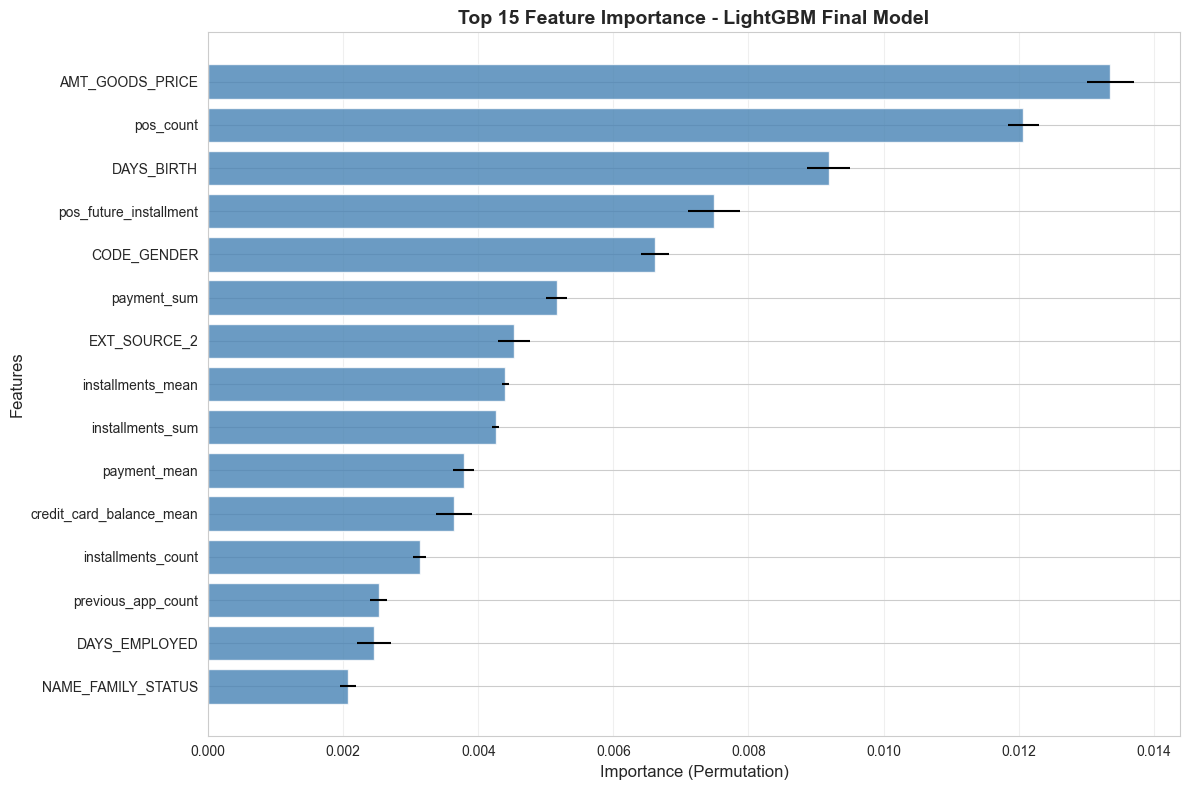

✅ Graphique Feature Importance Barplot sauvegardé

Top 15 features (Permutation):
                 feature  importance      std
         AMT_GOODS_PRICE    0.013358 0.000345
               pos_count    0.012068 0.000231
              DAYS_BIRTH    0.009190 0.000318
  pos_future_installment    0.007488 0.000390
             CODE_GENDER    0.006617 0.000207
             payment_sum    0.005163 0.000153
            EXT_SOURCE_2    0.004524 0.000238
       installments_mean    0.004397 0.000052
        installments_sum    0.004258 0.000055
            payment_mean    0.003783 0.000156
credit_card_balance_mean    0.003640 0.000264
      installments_count    0.003132 0.000094
      previous_app_count    0.002528 0.000125
           DAYS_EMPLOYED    0.002457 0.000256
      NAME_FAMILY_STATUS    0.002067 0.000119


In [39]:
print("\n=== FEATURE IMPORTANCE - GLOBAL BARPLOT ===")

# Combiner les importances de permutation pour un graphique global
top_n = 15
top_features = perm_df.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'].values, xerr=top_features['std'].values, color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel("Importance (Permutation)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title(f"Top {top_n} Feature Importance - LightGBM Final Model", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(MODELS_DIR / 'feature_importance_barplot.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"✅ Graphique Feature Importance Barplot sauvegardé")
print(f"\nTop {top_n} features (Permutation):")
print(top_features.to_string(index=False))